In [ ]:
%%capture

%cd ..

## Get MMLU and MuTual (no speaker tags) contexts

In [ ]:
from pathlib import Path
from typing import List, Optional, Union

from datasets import DatasetDict, load_dataset

from baseline.conf import DATA_DIR
from baseline.multi_choice.utils_multiple_choice import MuTualProcessor, InputExample


def get_mmlu_contexts(
    mmlu: Optional[DatasetDict] = None,
    subset: str = "all",
    split: str = "auxiliary_train",
) -> List[str]:
    """"""
    valid_splits = ["auxiliary_train", "test", "validation", "dev"]
    assert (
        split in valid_splits
    ), f"Unknown MMLU split {split!r}, available: {valid_splits}"
    if mmlu is None:
        mmlu = load_dataset("cais/mmlu", name=subset)
    return [dp["question"] for dp in mmlu[split]]


def get_mutual_contexts(
    data_dir: Union[Path, str] = DATA_DIR,
    subset: str = "mutual_plus",
    processor: Optional[MuTualProcessor] = None,
    split: str = "train",
    remove_context_speakers: bool = True,
) -> List[str]:
    """"""
    valid_splits, valid_subsets = ["train", "dev", "test"], ["mutual", "mutual_plus"]
    assert (
        split in valid_splits
    ), f"Unknown MuTual split {split!r}, available: {valid_splits}"
    assert (
        subset in valid_subsets
    ), f"Unknown MuTual subset {subset!r}, available: {valid_subsets}"
    if processor is None:
        processor = MuTualProcessor()
    data_split: List[InputExample] = getattr(processor, f"get_{split}_examples")(
        Path(data_dir) / subset
    )
    if remove_context_speakers:
        for dp in data_split:
            dp.inplace_remove_speakers(process_endings=False)
    return [dp.contexts[0] for dp in data_split]


In [ ]:
mmlu = load_dataset("cais/mmlu", name="all")
mmlu


Found cached dataset mmlu (/home/scur0643/.cache/huggingface/datasets/cais___mmlu/all/1.0.0/1f5be36877bf67bdc9a548113a281aec5730e14ead069b31cb63971b9fab210d)


  0%|          | 0/4 [00:00<?, ?it/s]

DatasetDict({
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
})

In [ ]:
mmlu_train_ctx = get_mmlu_contexts(mmlu=mmlu)
print(len(mmlu_train_ctx))
print(mmlu["auxiliary_train"][0]["question"])
print(mmlu_train_ctx[0])


99842
Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were
Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were


In [ ]:
mutual_processor = MuTualProcessor()
mutualplus_train_ctx = get_mutual_contexts(processor=mutual_processor)
print(len(mutualplus_train_ctx))
print(mutual_processor.get_train_examples(DATA_DIR / "mutual_plus")[0].contexts[0])
print(mutualplus_train_ctx[0])


read files:   0%|          | 0/7088 [00:00<?, ?it/s]

read files: 100%|██████████| 7088/7088 [00:03<00:00, 2328.72it/s]


7088


read files: 100%|██████████| 7088/7088 [00:00<00:00, 17249.99it/s]

F: Hi, can I help you? M: I hope so. My name is Mark. I'm... F: Don't I remember you from last year? You worked in, uh, where was it? The art library? M: You have a good memory. Yeah, that was me, and I really enjoyed the work. But for this year. F: Well, if you come in earlier. You could probably have gotten the library job again, but now... M: I plan to get a job in a restaurant this year. I really need it to make more money and working as a waiter. There always the tips. But I've tried a ton of places and I haven't found anything, and then my friend Susan. She takes photography classes in Harrison Hall. And she sort of thought there might be an opening there.
Hi, can I help you? I hope so. My name is Mark. I'm... Don't I remember you from last year? You worked in, uh, where was it? The art library? You have a good memory. Yeah, that was me, and I really enjoyed the work. But for this year. Well, if you come in earlier. You could probably have gotten the library job again, but now...

## EDA

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model_case_map = {"all-MiniLM-L6-v2": True}

embedding_model_name = "all-MiniLM-L6-v2"
embedder = HuggingFaceEmbeddings(model_name=embedding_model_name)
embedder


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False)

### Does using uncased text make a difference?

Some embedding models, like `all-MiniLM-L6-v2`, are trained on *lower-cased* text. However, seeing frome these examples,
it doesn't make a big difference whether text is lower-cased by tokenizer. If the embeddings are compared with a 
tolerance level lower than `1e-7`, then some array elements show an (overly) sensible difference!

In [ ]:
import numpy as np

cased_mutual_s = np.random.choice(mutualplus_train_ctx)
uncased_mutual_s = cased_mutual_s.lower()
print(cased_mutual_s)
print(uncased_mutual_s)

x = np.array(embedder.embed_documents([cased_mutual_s, uncased_mutual_s]))
print((x[0] - x[1]).min())
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))

x = np.array(embedder.embed_documents([uncased_mutual_s, uncased_mutual_s]))
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))
# print(x[0] - x[1])


Good morning. Morning. Come in. Sit down. Now, you're a new patient, aren't you? Yes, that's right. OK. So I better ask you some questions first. Now, have you ever had any serious illnesses or accidents? A broken leg I got from playing football when I was 17. I was in the school team at that time. Anything else? No. Apart from that, nothing. And have you had any operations of any kind? Now the only time I've been to hospital before was when I broke my leg. Fine. Any allergies? Yes, to dust and cats. How do you react? They both make me sneeze a bit. Nothing else.
good morning. morning. come in. sit down. now, you're a new patient, aren't you? yes, that's right. ok. so i better ask you some questions first. now, have you ever had any serious illnesses or accidents? a broken leg i got from playing football when i was 17. i was in the school team at that time. anything else? no. apart from that, nothing. and have you had any operations of any kind? now the only time i've been to hospital 

In [ ]:
# tell the tokenizer to lower-case text before embedding
embedder.client[0].do_lower_case = embedding_model_case_map[embedding_model_name]

x = np.array(embedder.embed_documents([cased_mutual_s, uncased_mutual_s]))
print((x[0] - x[1]).min())
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))

x = np.array(embedder.embed_documents([uncased_mutual_s, uncased_mutual_s]))
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))
# print(x[0] - x[1])


0.0
True
(array([], dtype=int64),)
True
(array([], dtype=int64),)


### Tokens: amount of texts that would exceed model's context size - `max_seq_length` property

In [ ]:
embedder.client[0].tokenizer

BertTokenizerFast(name_or_path='/home/scur0643/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
from tqdm import trange


def count_exceeding_tokens(
    tokenizer, max_len: int, dataset: List[str], dataset_name: str, batch_size: int = -1
):
    exceeding, n_data = [], len(dataset)
    # process in batch because a large dataset (~100k) won't work
    if batch_size < 0:
        batch_size = n_data
    for i in trange(0, n_data, batch_size):
        end = min(i + batch_size, n_data)
        toks = tokenizer(dataset[i:end])["input_ids"]
        exceeding += [
            (i, n_toks)
            for i, s_toks in enumerate(toks)
            if (n_toks := len(s_toks)) > max_len
        ]
    exceeding_dict = dict(zip(["index", "n_toks"], zip(*exceeding)))
    min_exceeding = min(exceeding_dict["n_toks"])
    max_exceeding = max(exceeding_dict["n_toks"])
    n_exceeding = len(exceeding_dict["index"])
    prop_exceeding = n_exceeding / n_data
    print(
        f"{dataset_name}: {n_exceeding}/{n_data} ({prop_exceeding * 100:.3f}%) exceed allowed len {max_len}, min {min_exceeding} max {max_exceeding}"
    )
    return exceeding_dict

In [ ]:
mutualplus_exceeding = count_exceeding_tokens(
    embedder.client[0].tokenizer,
    embedder.client[0].max_seq_length,
    mutualplus_train_ctx,
    "mutualplus_train",
)

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

mutualplus_train: 106/7088 (1.495%) exceed allowed len 256, min 257 max 394


For MuTual (plus), only 1.5% of the contexts won't fit in the encoder's context window and has to be broken down across
multiple batches (prevents full self-attention). This is not a major issue.

In [ ]:
mmlu_exceeding = count_exceeding_tokens(
    embedder.client[0].tokenizer,
    embedder.client[0].max_seq_length,
    mmlu_train_ctx,
    "mmlu_train",
    batch_size=int(1e4)
)

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 10/10 [00:41<00:00,  4.12s/it]

mmlu_train: 70988/99842 (71.100%) exceed allowed len 256, min 257 max 1472


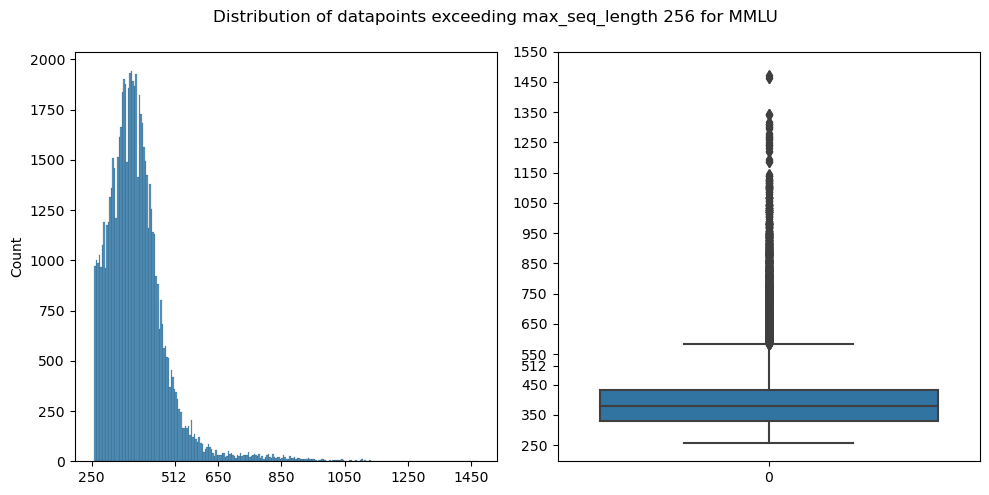

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(mmlu_exceeding["n_toks"], ax=axes[0])
axes[0].set_xticks(np.delete(np.sort(np.append(np.arange(250.0, 1600, 200), 512.0)), 1))
sns.boxplot(mmlu_exceeding["n_toks"], ax=axes[1])
axes[1].set_yticks(np.sort(np.append(np.arange(250.0, 1600, 100), 512.0)))
fig.suptitle(
    f"Distribution of datapoints exceeding max_seq_length {embedder.client[0].max_seq_length} for MMLU"
)
plt.tight_layout()

For MMLU this is more problematic, as 71% of datapoints exceed the max context length of 256. However, more than 75% of 
these overly long contexts are below 512 tokens in length, so we can opt for a model with larger context size to recover
them.

### Conclusion: use encoder model with larger context window

`multi-qa-mpnet-base-dot-v1` is the [most performant](https://www.sbert.net/docs/pretrained_models.html#model-overview) in 
Semantic Search tasks, therefore apt for our requirements.

In [ ]:
embedding_model_name = "multi-qa-mpnet-base-dot-v1"
embedder = HuggingFaceEmbeddings(model_name=embedding_model_name)
embedder

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
), model_name='multi-qa-mpnet-base-dot-v1', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False)

In [ ]:
embedder.client[0].max_seq_length, embedder.client[0].tokenizer

(512,
 MPNetTokenizerFast(name_or_path='/home/scur0643/.cache/torch/sentence_transformers/sentence-transformers_multi-qa-mpnet-base-dot-v1/', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True))

In [ ]:
mmlu_exceeding = count_exceeding_tokens(
    embedder.client[0].tokenizer,
    embedder.client[0].max_seq_length,
    mmlu_train_ctx,
    "mmlu_train",
    batch_size=int(1e4)
)

100%|██████████| 10/10 [00:36<00:00,  3.62s/it]

mmlu_train: 5482/99842 (5.491%) exceed allowed len 512, min 513 max 1472


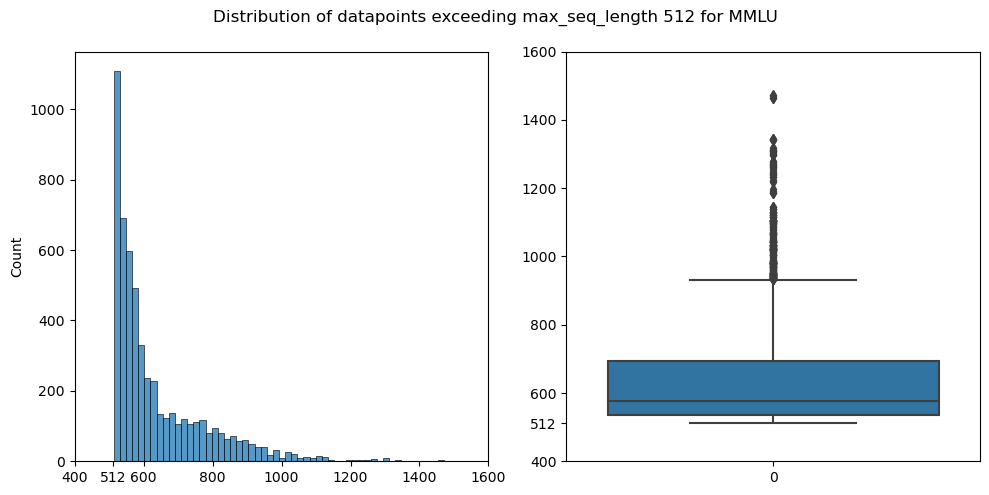

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(mmlu_exceeding["n_toks"], ax=axes[0])
axes[0].set_xticks(np.insert(axes[0].get_xticks(), 0, 512))
sns.boxplot(mmlu_exceeding["n_toks"], ax=axes[1])
axes[1].set_yticks(np.insert(axes[1].get_yticks(), 0, 512))
fig.suptitle(
    f"Distribution of datapoints exceeding max_seq_length {embedder.client[0].max_seq_length} for MMLU"
)
plt.tight_layout()

Now only 5.5% of MMLU train datapoints exceed the encoder's max sequence length. We do not check on the dev and train 
splits, as the train split should be representative enough.

## Embed the documents into a [FAISS](https://github.com/facebookresearch/faiss) vector database

#### MutualPlus train split

In [ ]:
from langchain.schema.embeddings import Embeddings
from langchain.vectorstores import FAISS, VectorStore

from baseline.conf import VECTORDB_DIR


def make_vectordb_dir_name(
    subset: str,
    split: str,
    model_name: str,
    vectordb_root: Union[Path, str] = VECTORDB_DIR,
) -> str:
    return str(vectordb_root / f"{subset}__{split}__{model_name}")


def create_or_load_vectordb(
    savedir: Union[str, Path],
    embedder: Embeddings,
    dataset: Optional[List[str]] = None,
    index_name: Optional[str] = None,
) -> VectorStore:
    savedir = Path(savedir)
    # when not given, assume index name is leaf folder name
    if index_name is None:
        index_name = savedir.stem
    if savedir.is_dir():
        print(f"Loading FAISS db with index {index_name!r} from {str(savedir)!r}")
        return FAISS.load_local(savedir, embedder, index_name)
    assert dataset is not None
    print(f"Creating FAISS db")
    db = FAISS.from_texts(dataset, embedder)
    db.save_local(savedir, index_name)
    print(f"Saved FAISS db with index {index_name!r} from {savedir!r}")
    return db

In [ ]:
mutualplus_db_name = make_vectordb_dir_name(
    "mutual_plus", "train", embedding_model_name
)
mutualplus_db_name

'vector_db/mutual_plus__train__multi-qa-mpnet-base-dot-v1'

In [ ]:
mutualplus_db = create_or_load_vectordb(
    mutualplus_db_name, embedder, mutualplus_train_ctx
)

Loading FAISS db with index 'mutual_plus__train__multi-qa-mpnet-base-dot-v1' from 'vector_db/mutual_plus__train__multi-qa-mpnet-base-dot-v1'


In [ ]:
mutualplus_db.index, mutualplus_db.index.ntotal

(<faiss.swigfaiss_avx2.IndexFlat; proxy of <Swig Object of type 'faiss::IndexFlat *'> >,
 7088)

Searching a context from the same dataset should return the exact same context as an identity.

In [ ]:
print(cased_mutual_s)
mutualplus_db.similarity_search(cased_mutual_s)

Good morning. Morning. Come in. Sit down. Now, you're a new patient, aren't you? Yes, that's right. OK. So I better ask you some questions first. Now, have you ever had any serious illnesses or accidents? A broken leg I got from playing football when I was 17. I was in the school team at that time. Anything else? No. Apart from that, nothing. And have you had any operations of any kind? Now the only time I've been to hospital before was when I broke my leg. Fine. Any allergies? Yes, to dust and cats. How do you react? They both make me sneeze a bit. Nothing else.


[Document(page_content="Good morning. Morning. Come in. Sit down. Now, you're a new patient, aren't you? Yes, that's right. OK. So I better ask you some questions first. Now, have you ever had any serious illnesses or accidents? A broken leg I got from playing football when I was 17. I was in the school team at that time. Anything else? No. Apart from that, nothing. And have you had any operations of any kind? Now the only time I've been to hospital before was when I broke my leg. Fine. Any allergies? Yes, to dust and cats. How do you react? They both make me sneeze a bit. Nothing else.", metadata={}),
 Document(page_content="Good morning. Morning. Come in. Sit down. Now, you're a new patient, aren't you? Yes, that's right. OK. So I better ask you some questions first. Now, have you ever had any serious illnesses or accidents? A broken leg I got from playing football when I was 17. I was in the school team at that time. Anything else? No. Apart from that, nothing. And have you had any 

#### MMLU train split

Normally we would encode documents in the vector database along with some metadata -- e.g. for MuTual the file name of the
datapoint -- but right now we skip this, and will recreate the database if needed.

In [ ]:
mmlu_db_name = make_vectordb_dir_name("mmlu", "train", embedding_model_name)
mmlu_db_name

'vector_db/mmlu__train__multi-qa-mpnet-base-dot-v1'

I assessed that simply calling
```python
mmmlu_db = create_or_load_vectordb(mmlu_db_name, embedder, mmlu_train_ctx)
```
takes forever (>7min). So let's try to embed the MMLU documents in batches first, then to create 
the vector database. Note that `batch_size` is not the actual batch size, which is controlled
by the constructor of `HuggingFaceEmbedding` and defaults to 32.

In [ ]:
mmlu_db_dir = Path(mmlu_db_name)
if not mmlu_db_dir.is_dir():
    # approx 8min to run
    batch_size = int(1e4)
    mmlu_embeddings = np.zeros(
        (len(mmlu_train_ctx), embedder.client[1].word_embedding_dimension)
    )
    for i in trange(0, len(mmlu_train_ctx), batch_size):
        end = min(i + batch_size, len(mmlu_train_ctx))
        mmlu_embeddings[i:end, :] = np.array(
            embedder.embed_documents(mmlu_train_ctx[i:end])
        )
    print("Creating MMLU vector db")
    mmlu_db = FAISS.from_embeddings(list(zip(mmlu_train_ctx, mmlu_embeddings.tolist())), embedder)
    mmlu_db.save_local(mmlu_db_dir, mmlu_db_dir.stem)
    print(f"Saved MMLU vector db with index {mmlu_db_dir.stem!r} to {str(mmlu_db_dir)!r}")
else:
    print(f"Loading MMLU vector db with index {mmlu_db_dir.stem!r} from {str(mmlu_db_dir)!r}")
    mmlu_db = FAISS.load_local(mmlu_db_dir, embedder, mmlu_db_dir.stem)


Loading MMLU vector db with index 'mmlu__train__multi-qa-mpnet-base-dot-v1' from 'vector_db/mmlu__train__multi-qa-mpnet-base-dot-v1'


The dense vectors stored in the database can be retrieved with `.reconstruct()` method; the key passed is the same index
of the context as stored in the original list used to create the database, in case of a [`FlatIndex`](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#flat-indexes).

In [ ]:
query_idx = np.random.randint(0, len(mmlu_train_ctx) + 1)
print(query_idx)
mmlu_db.index.reconstruct(query_idx).shape

80870


(768,)

##### Query: `mmlu`, search: `mutual` (smaller search space).

In [ ]:
print(mmlu_train_ctx[query_idx])
print(mmlu_db.docstore.search(mmlu_db.index_to_docstore_id[query_idx]))
mutualplus_db.similarity_search_with_score_by_vector(
    mmlu_db.index.reconstruct(query_idx).tolist()
)

Sometimes we feel good, such as when we get good grades or when something good happens. Sometimes we feel bad, such as when we argue with our classmates or when the teachers criticize us. Both kinds of feelings are common. Of course, we all enjoy good feelings, but when we feel unhappy, sometimes we don't know what to do about it. Here is a plan that will help you when your feelings are bothering you. 1. ACCEPT your feelings. Say to yourself, "I am sad. " "I am scared. " "I am angry. " "I am embarrassed. " It's all right to have these feelings. 2. RELAX and have a rest before you act.  Take slow deep breaths   and relax your body. Imagine that you are in a safe place.  You can listen to some music or sing a beautiful song ! 3. THINK about ways to help yourself. Thinking helps you do something smart instead of hurting yourself or making things worse. 4. DO something to help yourself.  Maybe you can talk to someone, or do something you enjoy. _ , go back to Step 3. If you want to relax y

[(Document(page_content='Good day at school Bobby? Yeah, pretty good, except for one little thing. Then why do I have a sinking feeling in my stomach. Failed exams, your teacher wants to talk to me or?', metadata={}),
  34.901672),
 (Document(page_content="I feel terrible. I really need to relax. Do you know any good ways to fight stress? Yes. In fact, I read in a health magazine that you can drink 2 cups of lemon tea every day. That will be helpful to deal with stress. Lemon tea? That's right. Lemon tea makes you feel more relaxed. Besides, you should eat low stress foods like apples and grapes. Sounds very strange. I guess hamburgers and French fries cause stress. Right? Yes, hamburgers are stress food.", metadata={}),
  35.148117),
 (Document(page_content="You just don't know what I feel. Everything is getting worse because of him! Stop blaming other people. Be patient and think positively.", metadata={}),
  38.58486),
 (Document(page_content='I feel terrible. I really need to relax

##### Query: `mutual`, search: `mmlu`.

In [ ]:
query_idx = np.random.randint(0, len(mutualplus_train_ctx) + 1)
print(query_idx)

print(mutualplus_train_ctx[query_idx])
print(mutualplus_db.docstore.search(mutualplus_db.index_to_docstore_id[query_idx]))
mmlu_db.similarity_search_with_score_by_vector(
    mutualplus_db.index.reconstruct(query_idx).tolist()
)

4543
How do you like the party? Oh, I'm having so much fun. I hope it will last longer. Actually, I was coming over to tell you I'm going to leave now. I don't know anybody here but you. Oh, I'm sorry. I should have introduced you to more people here.
page_content="How do you like the party? Oh, I'm having so much fun. I hope it will last longer. Actually, I was coming over to tell you I'm going to leave now. I don't know anybody here but you. Oh, I'm sorry. I should have introduced you to more people here." metadata={}


[(Document(page_content="My name is Bill. I have a friend called Mike. Today is Mike's birthday. I'm at his birthday party. There are a lot of friends in his house. Some stand beside the table and enjoy the snacks and drinks. There is some food on the table. I like the chocolate and the fruit very much. Mike sits on the sofa and chats with some friends there. He wears a yellow T-shirt and a pair of blue jeans. He looks so cool today. Wow! The cake is really big. There are some candles   on it. Mike's friends begin to sing 'Happy Birthday' to Mike. Mike is very happy. He blows out   the candles and cuts the cake. Everyone has a good time at the party. There are a lot of friends at   _   birthday party.", metadata={}),
  23.373278),
 (Document(page_content='It was Christmas,and there was a big party in the house.Guests came and went,but the party went on.Then the bell rang.Several people shouted. "Come in!" and a small man opened the front door and came in.Nobody knew him,but the host we

## Conclusion & TODO

It seems that searching *over `MMLU`* with *queries from `mutual`* gives more accurate results than the contrary; intuitively
it makes sense, since MMLU is 10x mutual, a search mutual -> MMLU can be more fine grained over a larger semantic space.

Next action points:
1. Save metadata in both vectorstore such as the index of each document in its creation list. This is useful after 
   search is done, to check that the retrieved documents have a correspondent in the original list -- sometimes 
   candidates too similar one to the other are retrieved, and I have the suspect that they are just chunks of the same 
   document.
2. Understand what similarity metric is reported by default; for this one it seems lower = better.
3. Understand if we should use the query functionality of `FAISS` directly, which allows batched queries whereas the 
   LangChain interface accepts a single query vector.
4. Proceed with the experiments:

   1. Add variable amounts of similar `MMLU` datapoints to `MutualPlus`, train a classifier and evaluate.
   2. Experiment with similarity techinques (cosine, MMR, euclidean distance).
   3. Check if keeping speaker tags improves the quality of similar points detection, maybe the encoder has seen so much
      that it's able to figure out the dialogue structure.